In [2]:
library(keras)
library(dplyr) 
use_condaenv('r-tensorflow')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



The function get.scale returns a list with two parameters : first the mean, second the std. If the input is already centered (it has an attribute center which is taken up by attr), we extract the mean. If it's not, we put the mean by default at 0. If the input is already scale (it has an attribute scale), we extract the std, if it's not we put the std by default at 1.
The function scale.as enables to scale a data set X2 the same way X1 was scaled

In [3]:
get.scale <- function(scaled) {
  if ("scaled:center" %in% names(attributes(scaled))) {
      center <- attr(scaled, "scaled:center")
  } else {
      center <- rep(0, ncol(scaled))
  }
  if ("scaled:scale" %in% names(attributes(scaled))) {
      list(center, attr(scaled, "scaled:scale"))
  } else {
      list(center, rep(1., length(center)))
  }
}
scale.as.x <- function(x, scaled) {
  s <- get.scale(scaled)
  centered <- sweep(x, 2, s[[1]])
  sweep(centered, 2, s[[2]], FUN = "/")
}

In [4]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))


In [5]:
#searching for input variables with zero variance (without the varible Intensity)
x = train.data[, -c(2,3)]
y = train.data$VALENCE.PLEASANTNESS
x$Intensity <- as.numeric(train.data$Intensity)
idx.zero.var <- apply(x, 2, var) == 0
#x is the whole training data (only predictors)
x <- x[,!idx.zero.var]


test.x <- test.data[,-c(1,2)]

test.x$Intensity <- as.numeric(test.data$Intensity)
test.x <- test.x[,!idx.zero.var]

full.data = data.frame(x,y)

In [6]:
#Split the data between a training and a test set
set.seed(100)
len <- length(x[,1])
idx.train <- sample(1:len, 2/3*len)

train.x <- x[idx.train,]
train.y <- y[idx.train]
validation.x <- x[-idx.train,]
validation.y <- y[-idx.train]


train.x.prep <- scale(train.x, center = T, scale = T)
#train.y.prep <- scale(train.y, center = T, scale = T)

validation.x.scaled = scale.as.x(validation.x,train.x.prep)
#validation.y.scaled = scale.as.y(validation.y,train.y.prep)
#We have 472 rows in the training set, and 472 for the test set
#Training data is scaled 

test.x.scaled = scale.as.x(test.x,train.x.prep)

In [43]:
set.seed(100)
nn <- keras_model_sequential()
nn <- nn %>%
      layer_dense(units = 50, activation = 'relu', input_shape = c(dim(train.x)[2]),
                  kernel_regularizer = regularizer_l1(l = 0.01)) %>%
      layer_dropout(rate= 0.5)%>%
      layer_dense(units = 1, activation = 'relu')


In [44]:
nn %>% compile(optimizer = "adam", loss = "mean_squared_error", metrics = "")

In [63]:
set.seed(100)
batch_size = 200
epochs = 100
history <- nn %>% fit(as.matrix(train.x.prep),
                      as.matrix(train.y),
                      verbose = 1,
                      batch_size = batch_size,
                      validation_data = list(as.matrix(validation.x.scaled),as.matrix(validation.y)),
                      epochs = epochs)


`geom_smooth()` using formula 'y ~ x'


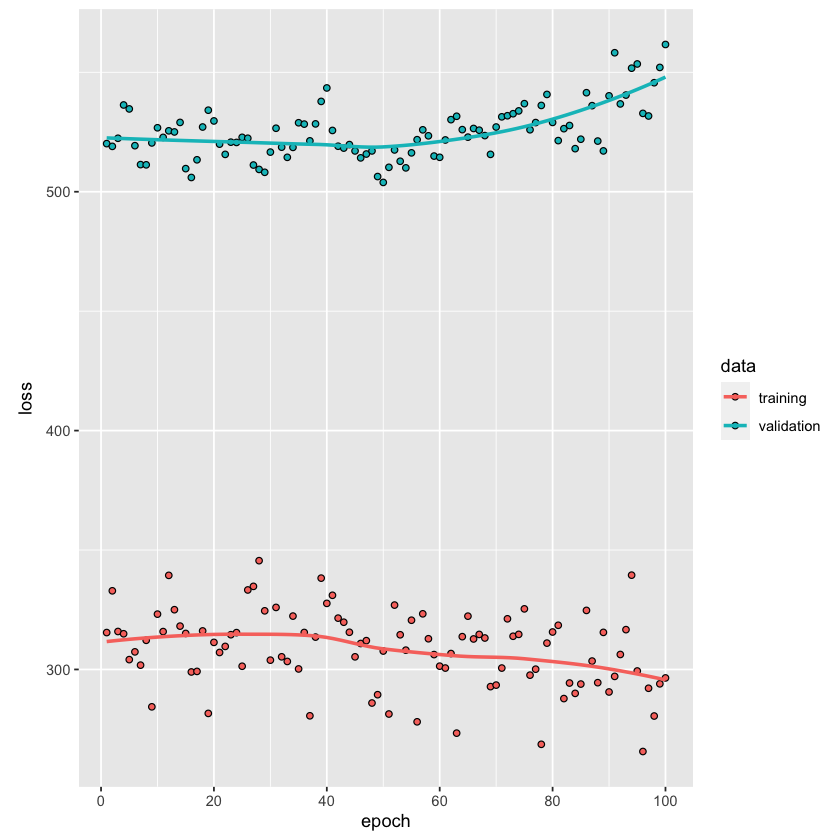

In [64]:
plot(history)


In [61]:
nn.pred <- predict(nn, as.matrix(validation.x.scaled))
sqrt(mean((nn.pred - validation.y)^2))

[1] 22.85386

In [62]:
prediction <- predict(nn, as.matrix(test.x.scaled))
prediction

16323.354
16604.738
21332.234
27104.424
11220.944
25814.492
10540.581
54714.863
4041.406
58059.562
15559.479
